# **Machine learning modeling**

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, matthews_corrcoef, roc_curve, confusion_matrix
from IPython.display import display
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')

# Loads data from the previous stage
file_path = '../data/df_eng.csv'
df = pd.read_csv(file_path, sep=';', encoding='iso-8859-1')

# Removes candidates who missed any exam, as it makes no sense to use them for score prediction. 
# A future idea is to create a model to predict absenteeism.
df = df[df['absent'] == 0] 
df

,age_range,mother_education,family_size,family_income,female_gender,private_school,trainee,absent,white_asian,black_pardo_indigenous,has_computer,high_objective_average,high_essay_score,high_overall_average
2,3,2,2,16,1,0,0,0,0,1,0,0,0,0
3,4,6,3,15,0,0,0,0,0,1,1,0,0,0
7,4,4,5,16,1,0,0,0,0,1,0,0,0,0
9,2,4,2,16,1,0,0,0,0,1,0,0,0,0
11,0,4,4,16,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476098,10,4,4,1,0,0,0,0,1,0,0,0,0,0
3476100,9,0,1,2,1,0,0,0,0,1,1,0,0,0
3476101,0,4,2,16,0,0,0,0,0,1,0,0,0,0
3476102,9,5,3,16,1,0,0,0,1,0,0,0,0,0


In [4]:
# Uses a random sample of 20% of the original data for model training and validation
max_candidates = df.shape[0] // 5

df_sample = df.sample(n=max_candidates, random_state=111) # Selects the random sample
df_remaining = df.drop(df_sample.index)                   # Removes the selected ones to form the remainder
del df

print(f'Sample size used for training and validation: {max_candidates}')

Sample size used for training and validation: 469380


## **Variables considered**

+ **'age_range'** - candidate's age, categorized by age groups.
+ **'mother_education'** - education level of the candidate's mother, represented in categories.
+ **'family_size'** - number of members in the candidate's household.
+ **'family_income'** - family income bracket declared by the candidate.
+ **'female_gender'** - indicates if the candidate is female (1 = yes, 0 = no).
+ **'private_school'** - indicates if the candidate attended private school during high school (1 = yes, 0 = no).
+ **'trainee'** - indicates if the candidate took the exam only for practice (1 = yes, 0 = no).
+ **'white_asian'** - indicates if the candidate self-identifies as white or asian (1 = yes, 0 = no).
+ **'black_pardo_indigenous'** - indicates if the candidate self-identifies as black, pardo, or indigenous (1 = yes, 0 = no).
+ **'has_computer'** - indicates if the candidate declared owning a computer at home (1 = yes, 0 = no).
#
**Target variable** - it was decided to choose only the **objective_average** as the target variable, since the essay score has a significant probability of being zeroed, regardless of socioeconomic factors. Recalling that, in the previous stage, a high average was considered if it exceeded the average of all candidates plus one standard deviation (**> 593.73**).

## **Class balancing**

In [5]:
# Defines the target variable and features
X = df_sample.drop(columns=['high_objective_average', 'high_essay_score', 'high_overall_average', 'absent'])
y = df_sample['high_objective_average']

# Splits the data into training (80%) and validation (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111, stratify=y)

# Checks the class balance
class_distribution = y_train.value_counts(normalize=True)
print('Class distribution before balancing:')
print(class_distribution)

# If there is an imbalance, applies oversampling (SMOTE) or undersampling
threshold = 0.4 # If a class has less than 40% of the examples, it is considered imbalanced

min_class_ratio = class_distribution.min()

if min_class_ratio < threshold:
    print('\nApplying balancing with SMOTE...')
    smote = SMOTE(random_state=111)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
else:
    print('\nApplying balancing with undersampling...')
    undersample = RandomUnderSampler(random_state=111)
    X_train_bal, y_train_bal = undersample.fit_resample(X_train, y_train)

# Checks the new class distribution
new_class_distribution = pd.Series(y_train_bal).value_counts(normalize=True)
print('Class distribution after balancing:')
print(new_class_distribution)

Class distribution before balancing:
high_objective_average
0    0.832793
1    0.167207
Name: proportion, dtype: float64

Applying balancing with SMOTE...
Class distribution after balancing:
high_objective_average
0    0.5
1    0.5
Name: proportion, dtype: float64


## **Model training and validation on a sample of the original dataset (approximately 470,000 rows)**

Tree-based models were chosen for training because they offer several advantages:

+ Fast convergence
+ No need for scalers
+ Handle tabular data and non-linear relationships well
+ Robust against outliers

Metrics considered:

+ **AUC-ROC:** measures the model's ability to distinguish between classes. It ranges from 0 to 1; the higher the value, the better the separation between positives and negatives.
+ **MCC (Matthews correlation coefficient):** measures the correlation between predictions and actual values. It ranges from -1 to 1. MCC considers all four elements of the confusion matrix, unlike other metrics such as accuracy, precision, recall, and F1-score, which use at most three. Therefore, it is a good indicator of overall model performance in classification problems, especially with imbalanced classes.


Random Forest:
AUC-ROC: 0.7103
MCC: 0.3341


,precision,recall,f1-score,support
0,0.919991,0.741874,0.821388,78179.000000
1,0.345506,0.678665,0.457898,15697.000000
accuracy,0.731305,0.731305,0.731305,0.731305
macro avg,0.632749,0.710270,0.639643,93876.000000
weighted avg,0.823932,0.731305,0.760609,93876.000000


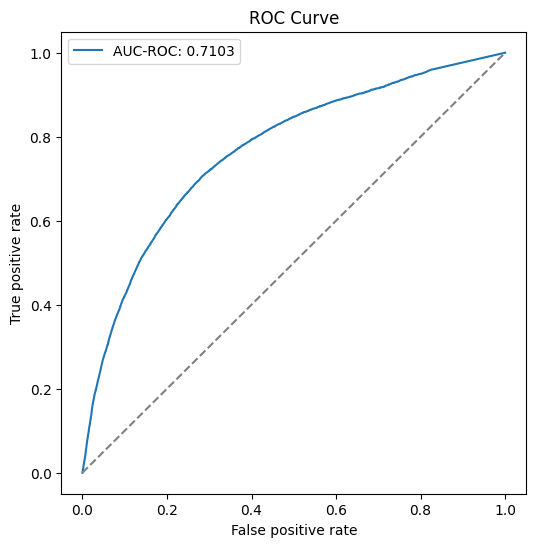

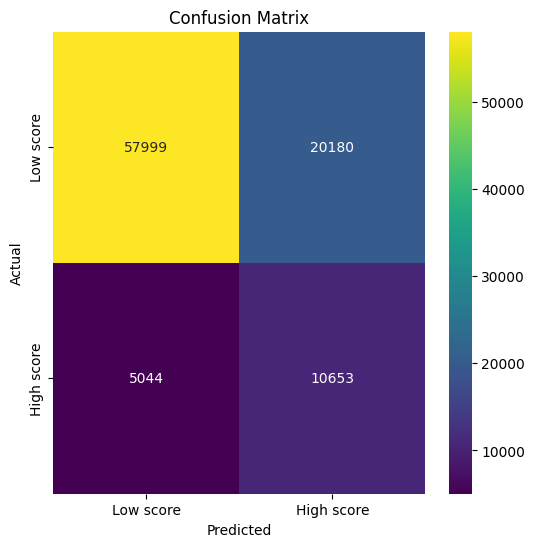


XGBoost:
AUC-ROC: 0.7456
MCC: 0.3838


,precision,recall,f1-score,support
0,0.938305,0.730298,0.821337,78179.000000
1,0.361602,0.760846,0.490221,15697.000000
accuracy,0.735406,0.735406,0.735406,0.735406
macro avg,0.649954,0.745572,0.655779,93876.000000
weighted avg,0.841875,0.735406,0.765971,93876.000000


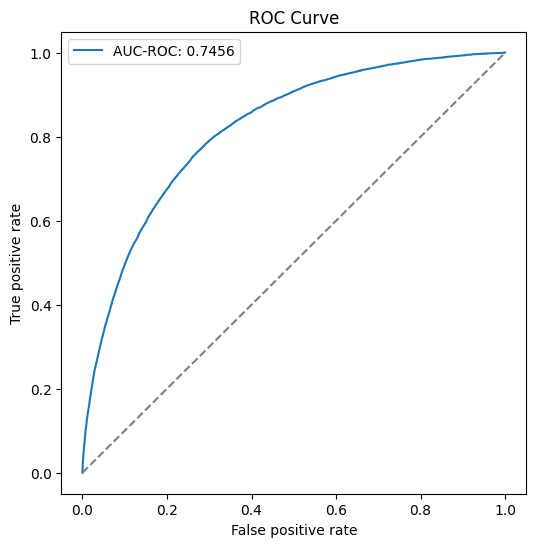

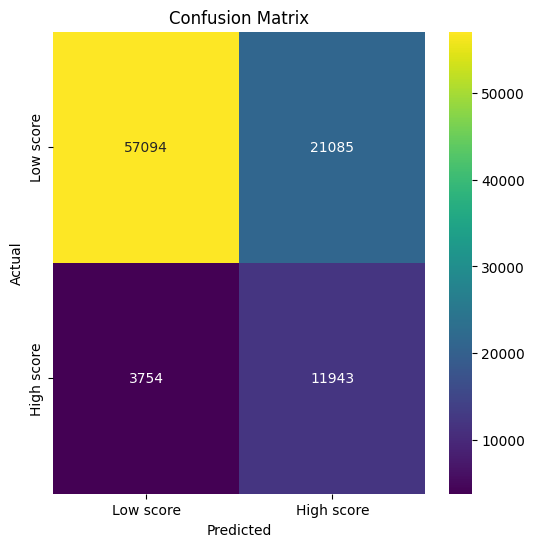

Best XGBoost hyperparameters:
{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 200}

Optimized XGBoost:
AUC-ROC: 0.7317
MCC: 0.3652


,precision,recall,f1-score,support
0,0.930470,0.738101,0.823196,78179.00000
1,0.357345,0.725298,0.478794,15697.00000
accuracy,0.735960,0.735960,0.735960,0.73596
macro avg,0.643907,0.731699,0.650995,93876.00000
weighted avg,0.834637,0.735960,0.765609,93876.00000


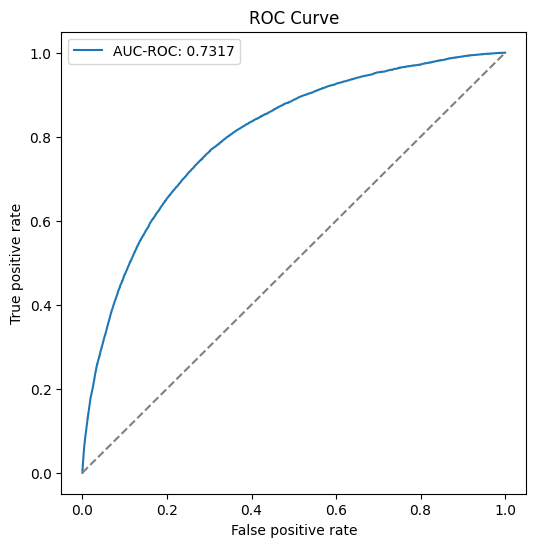

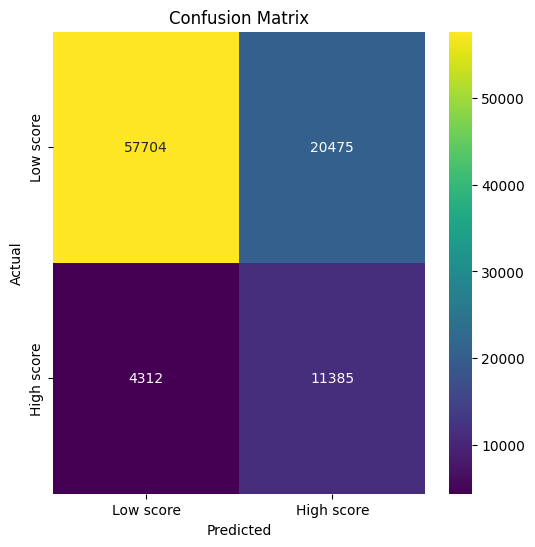

The best model in AUC-ROC was: XGBoost with 0.7456
The best model in MCC was: XGBoost with 0.3838
Feature Importance:


,Feature,Importance
9,has_computer,0.618779
6,trainee,0.093437
3,family_income,0.071855
8,black_pardo_indigenous,0.044665
4,female_gender,0.041784
5,private_school,0.037832
1,mother_education,0.031212
0,age_range,0.023458
2,family_size,0.021514
7,white_asian,0.015464


In [6]:
# Function to train, evaluate, and generate model plots
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probabilities for the ROC curve

    # Calculates AUC-ROC
    auc = roc_auc_score(y_test, y_pred)
    print(f'AUC-ROC: {auc:.4f}')

    # Calculates MCC
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f'MCC: {mcc:.4f}')

    # Converts the classification report into a dataframe
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Displays the dataframe with metrics
    display(report_df)

    # Plots the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC: {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Plots the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low score', 'High score'], yticklabels=['Low score', 'High score'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return auc, mcc

# Trains the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=111)
print('\nRandom Forest:')
auc_rf, mcc_rf = evaluate_model(rf, X_train_bal, X_test, y_train_bal, y_test)

# Trains the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111)
print('\nXGBoost:')
auc_xgb, mcc_xgb = evaluate_model(xgb_model, X_train_bal, X_test, y_train_bal, y_test)

# Optimizes XGBoost hyperparameters with grid search and 5-fold CV
param_grid_xgb = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111),
                               param_grid_xgb, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train_bal, y_train_bal)

print('Best XGBoost hyperparameters:')
print(grid_search_xgb.best_params_)

print('\nOptimized XGBoost:')
auc_xgb_opt, mcc_xgb_opt = evaluate_model(grid_search_xgb.best_estimator_, X_train_bal, X_test, y_train_bal, y_test)

# Compares models
auc_results = {
    'Random Forest': auc_rf,
    'XGBoost': auc_xgb,
    'Optimized XGBoost': auc_xgb_opt
}

mcc_results = {
    'Random Forest': mcc_rf,
    'XGBoost': mcc_xgb,
    'Optimized XGBoost': mcc_xgb_opt
}

best_model_auc = max(auc_results, key=auc_results.get)
best_model_mcc = max(mcc_results, key=mcc_results.get)

print(f'The best model in AUC-ROC was: {best_model_auc} with {auc_results[best_model_auc]:.4f}')
print(f'The best model in MCC was: {best_model_mcc} with {mcc_results[best_model_mcc]:.4f}')

# Analyzes feature importance of the best model based on AUC-ROC
importances = grid_search_xgb.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print('Feature Importance:')
display(feature_importance)

**Feature Importance Analysis**

+ The variable **"has_computer"** showed the highest importance in the model, indicating that access to a computer may be strongly correlated with better performance on objective questions.

+ Other variables such as **"trainee"**, **"family_income"**, and **"black_pardo_indigenous"** also have relevant contributions, suggesting that socioeconomic factors and individual characteristics play a role in score prediction.

+ Variables like **"white_asian"**, **"family_size"**, and **"age_range"** had lower importance, suggesting that their impact on the model was more limited.

+ Analyzing feature importance can be useful for interpreting which factors are most associated with performance, but it does not imply causality.

## **Testing on the remaining 80% of the original dataset (approximately 1.9 million rows)**

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=111, ...)

Best model performance on unseen data:
AUC-ROC: 0.7428
MCC: 0.3794


,precision,recall,f1-score,support
0,0.937108,0.729175,0.820168,1.563491e+06
1,0.359357,0.756354,0.487225,3.140290e+05
accuracy,0.733721,0.733721,0.733721,7.337205e-01
macro avg,0.648233,0.742764,0.653696,1.877520e+06
weighted avg,0.840475,0.733721,0.764480,1.877520e+06


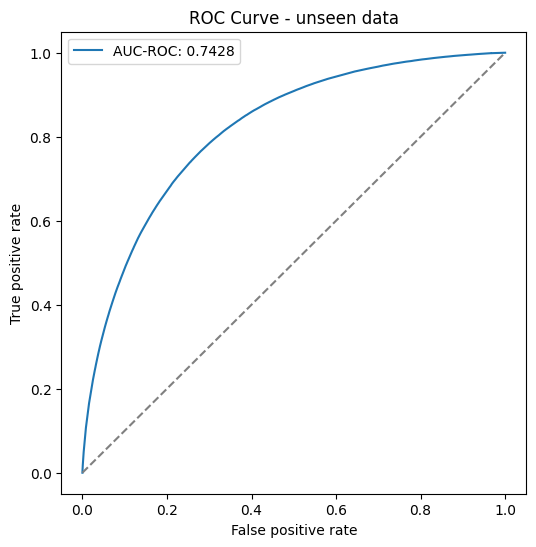

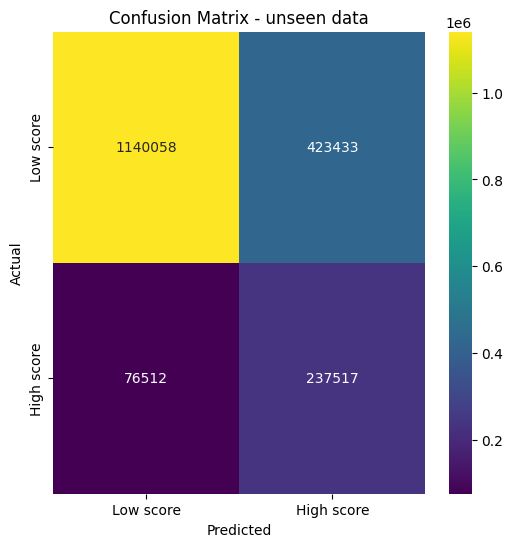

In [7]:
# Gets the best model based on AUC-ROC
best_model = (
    rf if best_model_auc == 'Random Forest' else
    xgb_model if best_model_auc == 'XGBoost' else
    grid_search_xgb.best_estimator_
)
print(best_model)

# Prepares input data for prediction on df_remaining
X_remaining = df_remaining.drop(columns=['high_objective_average', 'high_essay_score', 'high_overall_average', 'absent'])
y_remaining = df_remaining['high_objective_average']

# Makes predictions with the selected best model
y_pred_remaining = best_model.predict(X_remaining)
y_proba_remaining = best_model.predict_proba(X_remaining)[:, 1] # Probabilities for the ROC curve

# Evaluates performance on completely unseen data
auc_remaining = roc_auc_score(y_remaining, y_pred_remaining)
mcc_remaining = matthews_corrcoef(y_remaining, y_pred_remaining)

print('\nBest model performance on unseen data:')
print(f'AUC-ROC: {auc_remaining:.4f}')
print(f'MCC: {mcc_remaining:.4f}')

# Converts the classification report into a dataframe
report_dict_remaining = classification_report(y_remaining, y_pred_remaining, output_dict=True)
report_df_remaining = pd.DataFrame(report_dict_remaining).transpose()

# Displays the dataframe with metrics
display(report_df_remaining)

# Plots the ROC curve
fpr_remaining, tpr_remaining, _ = roc_curve(y_remaining, y_proba_remaining)
plt.figure(figsize=(6, 6))
plt.plot(fpr_remaining, tpr_remaining, label=f'AUC-ROC: {auc_remaining:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve - unseen data')
plt.legend()
plt.show()

# Plots the confusion matrix
cm_remaining = confusion_matrix(y_remaining, y_pred_remaining)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_remaining, annot=True, fmt='d', cmap='viridis', xticklabels=['Low score', 'High score'], yticklabels=['Low score', 'High score'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - unseen data')
plt.show()

## **Model performance analysis**

The model results indicate a good predictive capacity, considering the complexity of the problem and the available information. **The metrics were even better than those from the validation set.**

### **Main strengths:**
- **AUC-ROC = 0.7428** → the model shows a good ability to separate students with high and low scores. In real-world problems, values above 0.7 indicate a usable model.
- **MCC = 0.3794** → this value suggests a positive correlation between predictions and actual labels. Since the problem involves imbalance, an MCC above 0.3 is considered reasonable.
- **Recall for class 1 = 0.7564** → the model is able to correctly identify 75.64% of the students who actually have a high score, indicating that it is not ignoring this class.

### **Point for improvement:**
- **Precision for class 1 = 0.3594** → when the model predicts that a student has a high score, it is correct only 35.94% of the time. This suggests it may be generating many false positives.

---

### **Why is this problem difficult?**
The challenge of predicting the average score of objective questions based on socioeconomic characteristics lies in several factors:

1. **Unconsidered external factors** → academic performance does not depend solely on income, parental education, and access to resources. Other aspects, such as study habits, individual dedication, and psychological factors, are almost impossible to measure and were not represented in the data used.

2. **Noise in the data** → socioeconomic issues may influence the score but do not determine it. Students with similar profiles can have very different scores, making modeling difficult.

3. **Class imbalance** → if there are more students with low scores than high scores, the model may struggle to correctly predict the minority, which affects metrics like precision and MCC.

4. **Nature of ENEM** → the exam uses a grading method based on **Item Response Theory (IRT)**, which is not a simple sum of correct answers. This adds an extra layer of unpredictability, as the final score depends not only on the number of correct answers but also on the difficulty of the questions answered correctly.

5. **Arbitrary weighting** → the variables for age range, family income, and mother's education were arbitrarily encoded using Label Encoder, for the reasons explained in notebook 3. This may have affected the model quality.

---

### **Conclusion**
The model showed a good overall performance, with an AUC-ROC of 0.7428 and an MCC of 0.3794. However, the low precision for the high-score class (0.3594) might be a point of concern, especially if the goal is to minimize false positives.

In [8]:
# Saves the best model to a pickle file
import pickle
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(best_model, f)